# Qcodes Examples Basel Precision Instruments DAC 1060 24 channel

Copyright (c) Basel Precision Instruments GmbH (2024), written for the QCoDeS driver `Baspi_Lnhrdac2.py`, v0.2.0

...........................................................................................................................................................................................................................................

This notebook shows example usecases for the Basel Precision Instruments LNHR DAC II (SP1060) with 24 channels and AWG functionality.

## 1. DC voltages on individual channels

### 1.0 Imports

In [1]:
import random

# qcodes 
from qcodes import Station
from qcodes.utils.dataset.doNd import do1d, do2d
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter
from qcodes import  (Measurement,
                    experiments,
                    initialise_database,
                    initialise_or_create_database_at,
                    load_by_guid,
                    load_by_run_spec,
                    load_experiment,
                    load_last_experiment,
                    load_or_create_experiment,
                    new_experiment,
                    ManualParameter)


# Baspi Dac driver
from Baspi_Lnhrdac2 import BaspiLnhrdac2
# Gate and VirtualGateParameter classes for DC voltage sweeps
from qcodes_gate_parameters import GateParameter, VirtualGateParameter

In [2]:
sample_name = "example scans" # Sample name
exp_name = "BASPI LNHR DAC demo" # Experiment name


experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

In order to mimick measurements, we will define a dummy instrument as well as a dummy measurement parameter which we will use in the following examples. Calling the measurement parameter will return a random number:

In [3]:
#Random number parameter to mimick measurements in the example notebook
class RandomNumberParameter(Parameter):
    def get_raw(self):
        return random.random()

# Define a custom instrument
class RandomNumberInstrument(Instrument):
    def __init__(self, name):
        super().__init__(name)
        
        # Add the random number parameter to the instrument
        self.add_parameter('random_number',
                           parameter_class=RandomNumberParameter)
    def get_idn(self):
        return {
            "vendor": "BasPI",
            "model": str(self.__class__),
            "serial": "NA",
            "firmware": "NA",
        } 
        
# Instantiate the instrument
dummy_instrument = RandomNumberInstrument('random_instrument')

### 1.1 Setting up the DAC

Lets now instantiate the DAC:

Upon connecting to the dac, the current status of all chanels is displayed as well as the current voltage output values.

In [4]:
# The DAC is a visa instrument, find its visa adress e.g. using NI-MAX
dac = BaspiLnhrdac2('LNHRDAC', 'TCPIP0::192.168.0.5::23::SOCKET') 


Connected to: Basel Precision Instruments GmbH (BASPI) LNHR DAC II (SP1060) - 24 channel version (serial:SN 10600000011, firmware:Revision 3.4.9u) in 6.44s
All channels have been turned off (1 MOhm Pull-Down to AGND) upon initialization and are pre-set to 0.0 V if turned on without setting a voltage beforehand.



We can now add the DAC and the dummy instrument to the station:

In [5]:
station = Station()

# dummy instrument
station.add_component(dummy_instrument)

# Baspi DAC
station.add_component(dac)

'LNHRDAC'

### 1.2 Gate and Source Voltage Parameters using the GateParameter Class

In [6]:
# Access the random number parameter
dummy_measurement = dummy_instrument.random_number

#### 1.2.1 Gate Voltage Parameters

Use GateParameters to easily set and sweep DC voltages on any channel of the DAC.

For the 24-chanel version, use dac.chxy.volt with xy in {1,2,3, ... , 24} to access channel xy. 
The parameter name needs to be specified, the defauls unit it V.
The default value_range is (-10,10) and can be specified to prevent applying excessive voltages.

In [7]:
# Gate 1
V1 = GateParameter(dac.ch1.voltage,
                        name = "V_1",               
                        unit = "V",
                        value_range = (-10, 10),
                        )
# Gate 2
V2 = GateParameter(dac.ch2.voltage,
                        name = "V_2",
                        unit = "V",
                        value_range = (-1, 5),
                        )


#### 1.2.2 Source Voltage Parameter

Example source voltage parameter which is applied e.g. through a BasPI low noise high stability I/V converter SP083c.
The I/V converter input voltage is divided by 100, so we need to appropriately scale the DAC output.
An optional offset voltage can also be defined.

The dac will output the voltage according to V_output = V_input*scaling + offset on channel 10.
Note that the value of V_output must lie within the value_range.

Default parameters are scaling = 1; offset = 0

In [8]:
VSource = GateParameter(dac.ch10.voltage,
                        name = "V_S",
                        unit = "V",
                        value_range = (-2.5, 2.5),
                        scaling = 100,
                        offset = 0
                        )

Exemplary 1D sweep using the qcodes do1d method:

Starting experimental run with id: 31. Using 'qcodes.dataset.do1d'


  0%|          | 0/20 [00:00<?, ?it/s]

(results #31@C:\Users\Jan\experiments.db
 ---------------------------------------
 LNHRDAC_ch1_V_1 - numeric
 random_instrument_random_number - numeric,
 (<Axes: title={'center': 'Run #31, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_1 (V)', ylabel='random_number'>,),
 (None,))

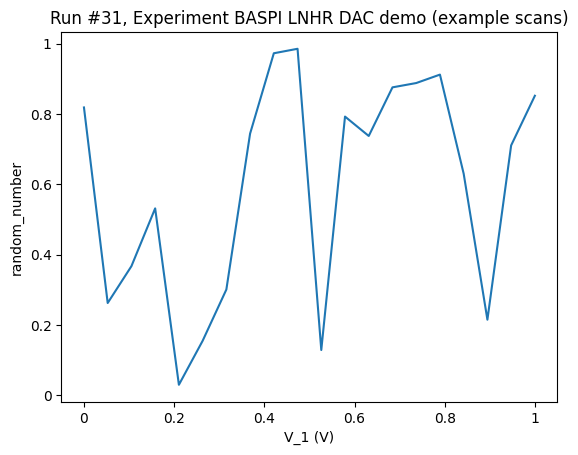

In [9]:
do1d(V1,0,1,20,0.001,dummy_measurement,show_progress=True, do_plot = True)

### 1.3 Linear Combinations of Gate voltages using VirtualGateParameter

#### 1.3.1 Synchronized Gate Parameters

We can simultanseusly address multiple gate parameters by listing them in a VirtualGateParameter. Here, the scaling and offsets are inherited from the parent parameters.

The parameters are listed to params as a tuple.

If scaling and offsets are provided, these must be tuples of the same length as params.

Note that if Vgates is set to a specific value, the underlying GateParameters are swept sequentially to the respective target voltage, following their listing order in params.

In [10]:
# V gates is a parameter that combines V1 and V2
Vgates= VirtualGateParameter(name = "V_gates",
                             params = (V1, V2),
                             set_scaling = (1,1)
                            )

Starting experimental run with id: 32. Using 'qcodes.dataset.do1d'


  0%|          | 0/10 [00:00<?, ?it/s]

(results #32@C:\Users\Jan\experiments.db
 ---------------------------------------
 LNHRDAC_ch1_V_gates - numeric
 random_instrument_random_number - numeric
 LNHRDAC_ch1_V_1 - numeric
 LNHRDAC_ch2_V_2 - numeric,
 (<Axes: title={'center': 'Run #32, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_gates (V)', ylabel='random_number'>,
  <Axes: title={'center': 'Run #32, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_gates (V)', ylabel='V_1 (V)'>,
  <Axes: title={'center': 'Run #32, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_gates (V)', ylabel='V_2 (V)'>),
 (None, None, None))

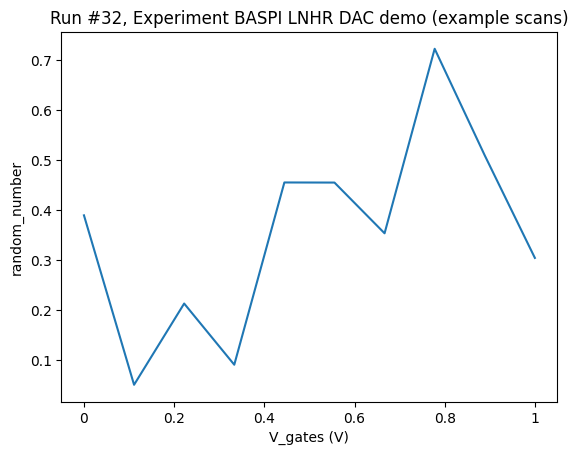

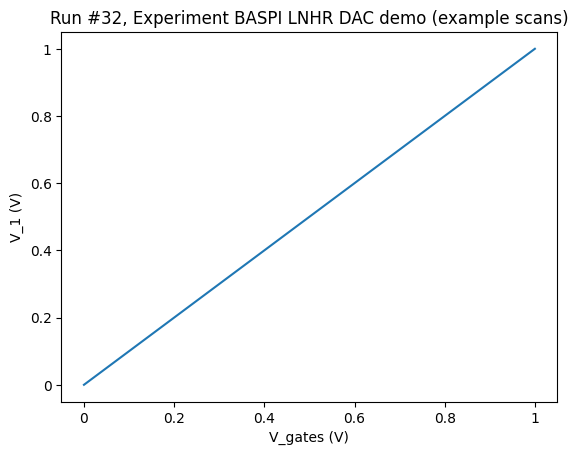

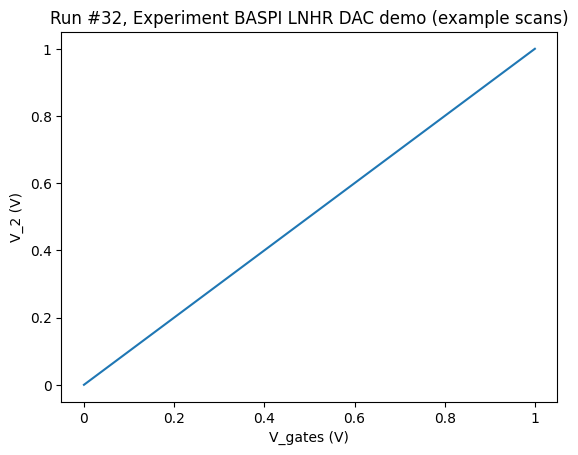

In [11]:
# Simultaneous sweeping of V1 and V2
do1d(Vgates,0,1,10,0.01,dummy_measurement,V1,V2,show_progress=True, do_plot = True)

#### 1.3.2 Virtual Gate composed of V1 and V2

The scaling and offsets on the two GateParameters can be chosen individually to create a virtualized gate. This is useful for instance when cross-capacitances are accounted for. 



In [12]:
# A virtualized gate parameter composed of V1 and V2
# The output voltages are calculated as V1 = 2*V_input + 0.5 and V2 = -1*V_input + 0.1
Vvirtual= VirtualGateParameter(name = "V_virtual",
                           params = (V1, V2),
                           set_scaling = (2,-1),
                           offsets = (0.5, 0.1))

Starting experimental run with id: 33. Using 'qcodes.dataset.do1d'


  0%|          | 0/10 [00:00<?, ?it/s]

(results #33@C:\Users\Jan\experiments.db
 ---------------------------------------
 LNHRDAC_ch1_V_virtual - numeric
 random_instrument_random_number - numeric
 LNHRDAC_ch1_V_1 - numeric
 LNHRDAC_ch2_V_2 - numeric,
 (<Axes: title={'center': 'Run #33, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_virtual (V)', ylabel='random_number'>,
  <Axes: title={'center': 'Run #33, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_virtual (V)', ylabel='V_1 (V)'>,
  <Axes: title={'center': 'Run #33, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_virtual (V)', ylabel='V_2 (mV)'>),
 (None, None, None))

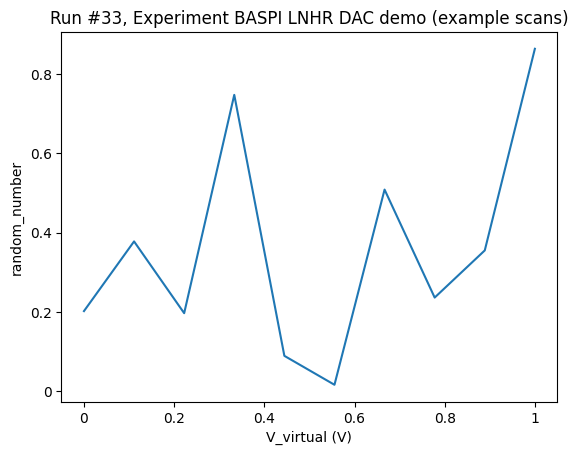

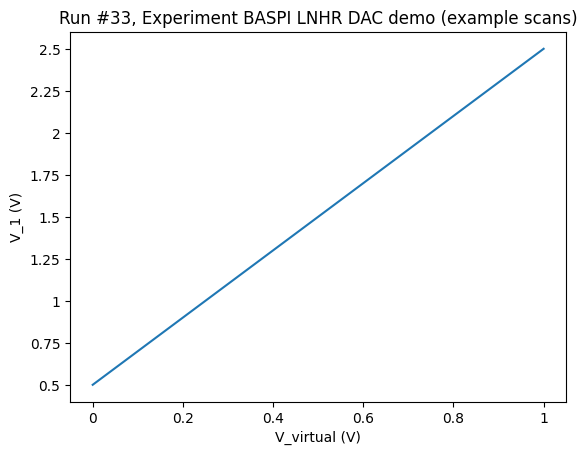

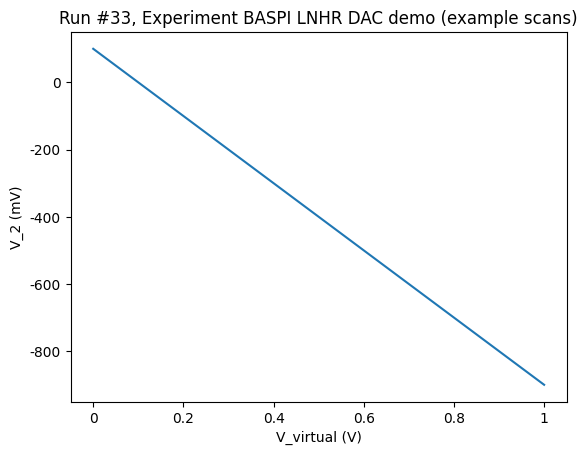

In [13]:
do1d(Vvirtual,0,1,10,0.01,dummy_measurement,V1,V2,show_progress=True, do_plot = True)

#### 1.3.3 Direct Definition without Gate Parameter

If the independent gate voltages are not supposed to be swept independently, a combined virtual gate parameter can also be defined directly:

In [14]:
Vdirect= VirtualGateParameter(name = "V_direct",
                           params = (dac.ch3.voltage, dac.ch4.voltage),
                           set_scaling = (0.5,2),
                           offsets = (1, 0))

Starting experimental run with id: 34. Using 'qcodes.dataset.do1d'


  0%|          | 0/10 [00:00<?, ?it/s]

(results #34@C:\Users\Jan\experiments.db
 ---------------------------------------
 LNHRDAC_ch3_V_direct - numeric
 random_instrument_random_number - numeric
 LNHRDAC_ch1_V_1 - numeric
 LNHRDAC_ch2_V_2 - numeric,
 (<Axes: title={'center': 'Run #34, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_direct (V)', ylabel='random_number'>,
  <Axes: title={'center': 'Run #34, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_direct (V)', ylabel='V_1 (V)'>,
  <Axes: title={'center': 'Run #34, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_direct (V)', ylabel='V_2 (mV)'>),
 (None, None, None))

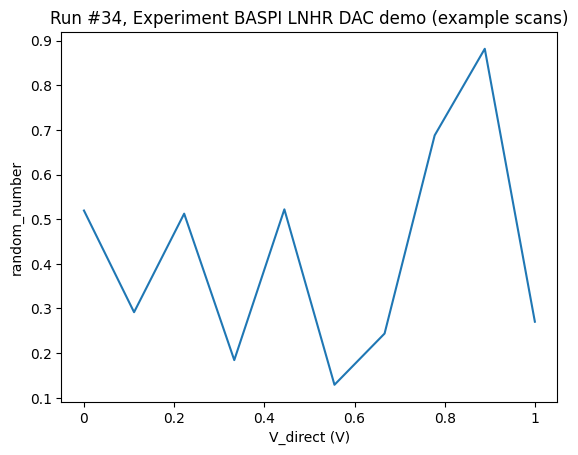

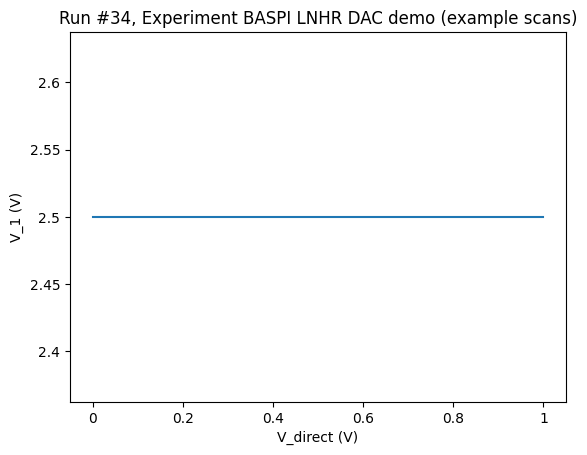

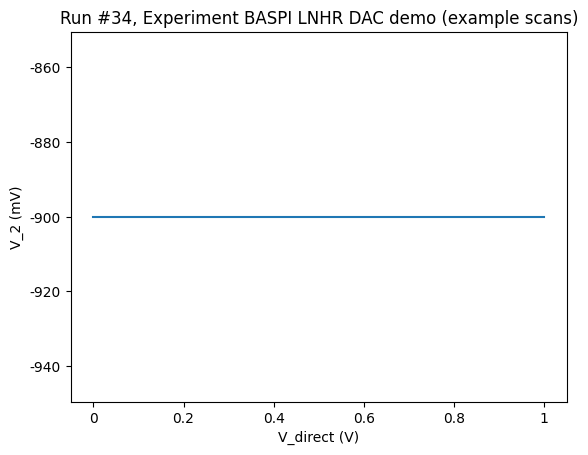

In [15]:
do1d(Vdirect,0,1,10,0.01,dummy_measurement,V1,V2,show_progress=True, do_plot = True)

### 1.4 Further Settings of DAC Channels

#### 1.4.1 Safety Limits

Each physical dac channel is assigned a safe ramp rate at initialisation to prevent too fast DC voltage swings e.g. when setting the voltage using a qcodes set sommand or when resetting the gate voltage on the fast axis of 2D scans. Two parameters are used:

inter_delay: The minimum wait time (in seconds) between two subsequent voltages are set. Set inter_delay to 0 if the maximum possible ramp speed should be used. Default value: 0.02 s.

step: Maximum increment of the channel output voltage. If the difference between the target voltage and the current output voltage is larger than step, it is broken into multiple steps of size step and in between subsequent steps, the inter_delay wait is applied. Default value 0.01 V.

The defaults are applied when initializing the dac and can be changed in the driver on lines 137 & 136. 

Individual channel setings can be read out and set as follos:

In [16]:
dac.ch1.voltage.inter_delay = 0.01  # setting the inter_delay of only channel 1

In [17]:
dac.ch1.voltage.inter_delay

0.01

In [18]:
dac.ch1.voltage.step = 0.1 

In [19]:
dac.ch1.voltage.step

0.1

In [20]:
dac.ch2.voltage.step

#### 1.4.2 Collective Actions on all Channels

By default, all channels are turned on upon dac initialisation. We can turn all channels off using all_off and back on using all_on.

In [21]:
dac.all_off() 

AttributeError: 'BaspiLnhrdac2' object and its delegates have no attribute 'all_off'

In [ ]:
print(dac.query_all())

In [ ]:
dac.all_on() 

In [ ]:
print(dac.query_all())

### 1.5 2D sweeps using Gate Parameters

We can use GateParameters as well as VirtualGateParameters also in the qcodes d2d method:

Starting experimental run with id: 35. Using 'qcodes.dataset.do2d'


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(results #35@C:\Users\Jan\experiments.db
 ---------------------------------------
 LNHRDAC_ch1_V_1 - numeric
 LNHRDAC_ch2_V_2 - numeric
 random_instrument_random_number - numeric,
 (<Axes: title={'center': 'Run #35, Experiment BASPI LNHR DAC demo (example scans)'}, xlabel='V_1 (V)', ylabel='V_2 (V)'>,),
 (<matplotlib.colorbar.Colorbar at 0x1c66ec608c0>,))

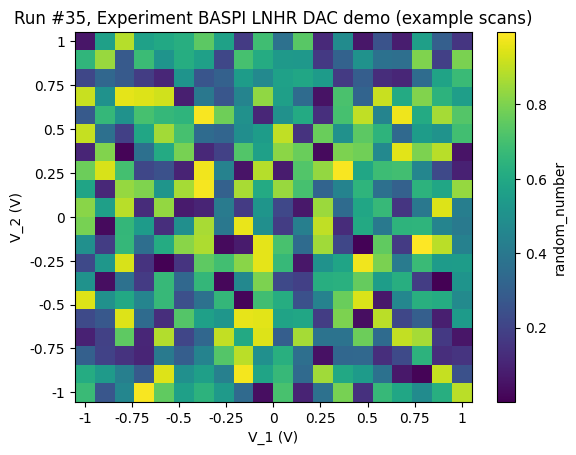

In [22]:
do2d(V1, -1,1,20,1,V2,-1,1,20,0.01,dummy_measurement,show_progress=True, do_plot = True)

In [ ]:
do2d(V1, -1,1,20,1,Vvirtual,-1,1,20,0.01,dummy_measurement,V2,show_progress=True, do_plot = True)